In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import zipfile
from skimage.color import lab2rgb, rgb2lab
from dataset import CelebADataset
from training import train_model #, load_model
import json
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from PIL import Image

## Simple Convolutional Autoencoder (CAE) for 112x112 Images

## With downloaded dataset

### Data Preparation

In [3]:
# Define a transform to convert images to grayscale and LAB
class RGBToGrayLAB:
    def __call__(self, img):
        img = np.array(img)
        lab = rgb2lab(img).astype("float32")
        l = lab[..., 0] / 100.0  # Scale L to [0, 1]
        ab = (lab[..., 1:] + 128) / 255.0  # Scale AB to [0, 1]
        return l, ab

    def __repr__(self):
        return self.__class__.__name__ + '()'

resize_transform = transforms.Resize((224, 224))

def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy()

# Function to load images and apply transformations
def load_and_transform_images(image_folder, resize_transform, rgb_to_graylab):
    l_images = []
    ab_images = []
    for filename in os.listdir(image_folder):
        if filename.endswith('.jpg'):
            img_path = os.path.join(image_folder, filename)
            img = Image.open(img_path).convert('RGB')
            img = resize_transform(img)
            l, ab = rgb_to_graylab(img)
            l_images.append(torch.tensor(l).unsqueeze(0))  # Add channel dimension
            ab_images.append(torch.tensor(ab).permute(2, 0, 1))  # Rearrange dimensions to (C, H, W)
    l_images = torch.stack(l_images)
    ab_images = torch.stack(ab_images)
    return l_images, ab_images

# Load and transform the images
image_folder = 'data/celebA/img_celeba'  # Replace with your images folder path
l_images, ab_images = load_and_transform_images(image_folder, resize_transform, RGBToGrayLAB())

# Inspección de los valores después de la transformación
print("Shape of L images:", l_images.shape)
print("Shape of AB images:", ab_images.shape)
print("L channel range:", l_images.min().item(), l_images.max().item())
print("AB channel range:", ab_images.min().item(), ab_images.max().item())

Shape of L images: torch.Size([998, 1, 224, 224])
Shape of AB images: torch.Size([998, 2, 224, 224])
L channel range: 0.0 1.0
AB channel range: 0.08048194646835327 0.8658087253570557


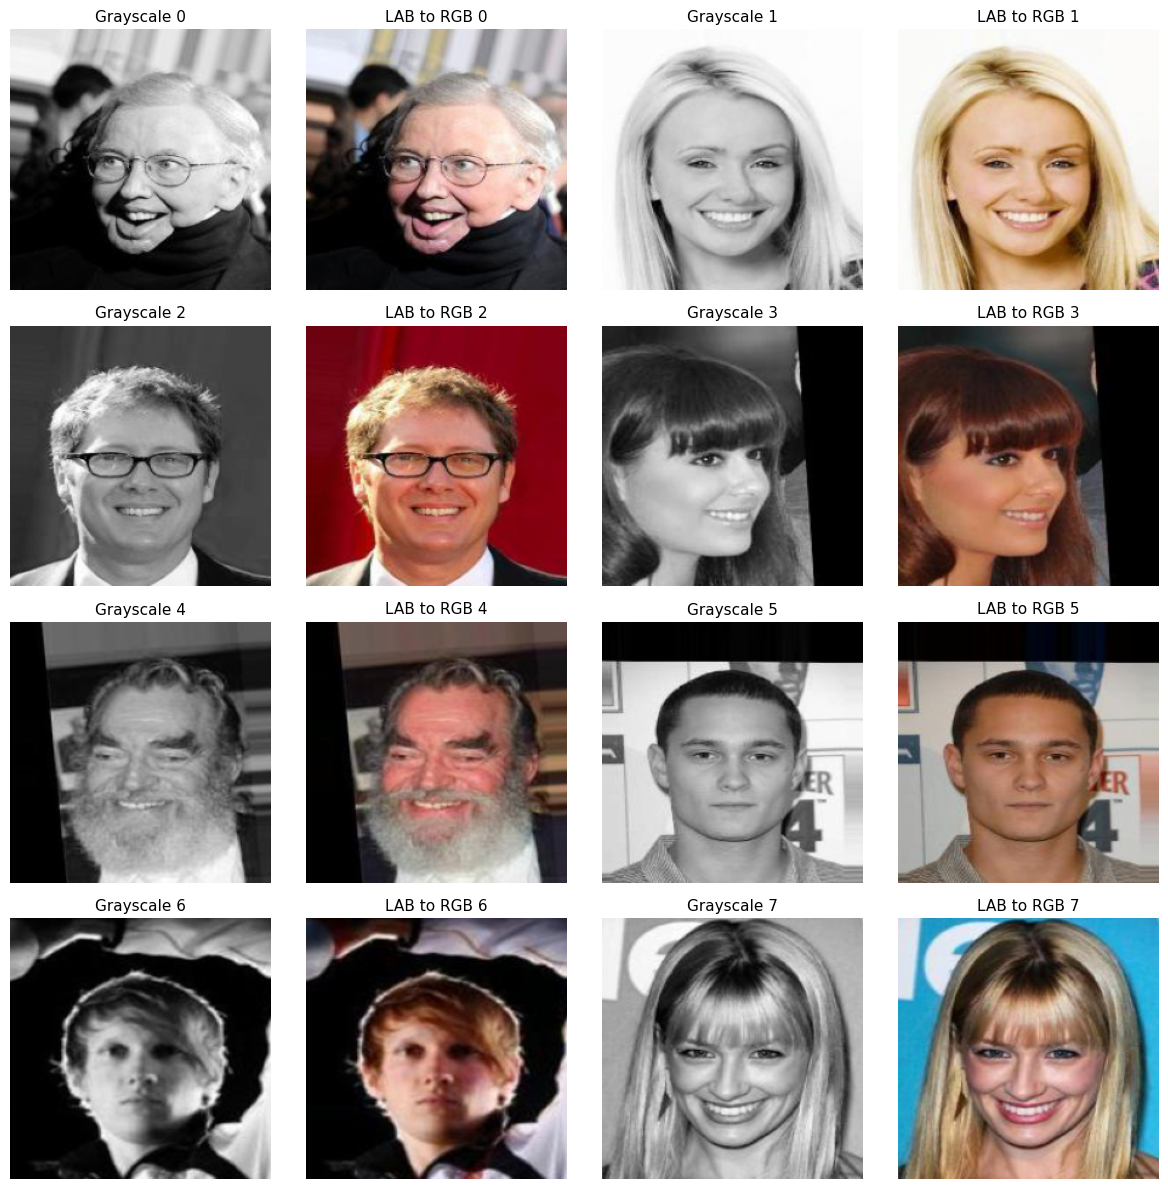

In [4]:
# Display some example images
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

for i in range(8):
    # Original image in grayscale
    axs[i//2, (i % 2) * 2].imshow(l_images[i].numpy().squeeze(), cmap='gray')
    axs[i//2, (i % 2) * 2].axis('off')
    axs[i//2, (i % 2) * 2].set_title(f'Grayscale {i}', fontsize=11)
    
    # Image in LAB color space
    img_lab = np.zeros((224, 224, 3), dtype=np.float32)
    img_lab[:,:,0] = l_images[i].numpy().squeeze() * 100  # L channel
    img_lab[:,:,1:] = (ab_images[i].numpy().transpose(1, 2, 0) * 255) - 128  # a and b channels
    img_rgb = lab2rgb(img_lab)
    axs[i//2, (i % 2) * 2 + 1].imshow(img_rgb)
    axs[i//2, (i % 2) * 2 + 1].axis('off')
    axs[i//2, (i % 2) * 2 + 1].set_title(f'LAB to RGB {i}', fontsize=11)

plt.tight_layout()
plt.show()

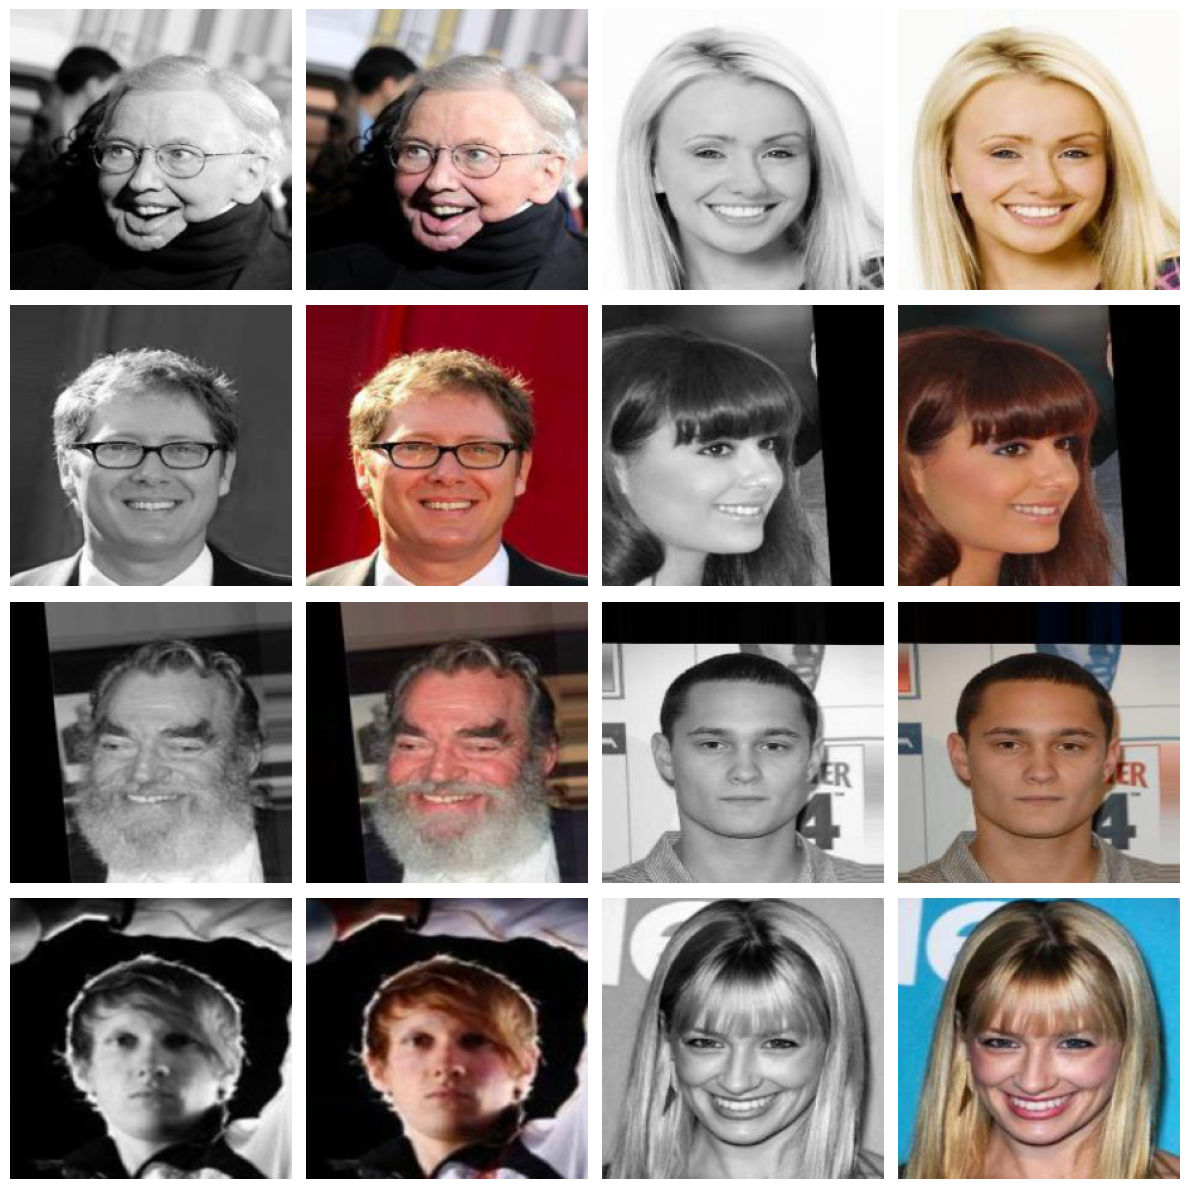

In [5]:
# Correct conversion function
def lab_to_rgb(L, ab):
    L = L * 100  # Escalar L de [0, 1] a [0, 100]
    ab = (ab * 255) - 128  # Escalar a y b de [0, 1] a [-128, 127]
    Lab = torch.cat([L, ab], dim=0).detach().cpu().numpy()  # Concatenar L y ab, y convertir a numpy
    img_rgb = lab2rgb(Lab.transpose(1, 2, 0))  # Transponer para tener la forma correcta
    return img_rgb

# Verificación y corrección en la visualización
def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy()

# Aquí solo mostramos el proceso de visualización
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i in range(8):
    # Imagen en escala de grises
    gray_image = tensor_to_numpy(l_images[i]).squeeze()
    axs[i//2, (i % 2) * 2].imshow(gray_image, cmap='gray')
    axs[i//2, (i % 2) * 2].axis('off')

    # Imagen colorizada
    img_rgb = lab_to_rgb(l_images[i], ab_images[i])
    axs[i//2, (i % 2) * 2 + 1].imshow(img_rgb)
    axs[i//2, (i % 2) * 2 + 1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Inspección de los valores después de la transformación
print("Shape of L images:", l_images.shape)
print("Shape of AB images:", ab_images.shape)

# Verificación de los valores de los canales
print("L channel range:", l_images.min().item(), l_images.max().item())
print("AB channel range:", ab_images.min().item(), ab_images.max().item())

Shape of L images: torch.Size([998, 1, 224, 224])
Shape of AB images: torch.Size([998, 2, 224, 224])
L channel range: 0.0 1.0
AB channel range: 0.08048194646835327 0.8658087253570557


### Data Loader

In [7]:
print(l_images.shape)
print(ab_images.shape)

torch.Size([998, 1, 224, 224])
torch.Size([998, 2, 224, 224])


In [8]:
batch_size = 32

# Prepare the Datasets
all_dataset = CelebADataset(l_images=l_images, ab_images=ab_images, reduced=False)

# Definir las proporciones para entrenamiento, validación y prueba
train_ratio = 0.75
valid_ratio = 0.15
test_ratio = 0.1

# Calcular las longitudes de cada conjunto
total_count = len(all_dataset)
train_count = int(total_count * train_ratio)
valid_count = int(total_count * valid_ratio)
test_count = total_count - train_count - valid_count  # Asegura que sumen el total

# Establecer la semilla para reproducibilidad
torch.manual_seed(42)

# Dividir el dataset
train_dataset, valid_dataset, test_dataset = random_split(all_dataset, [train_count, valid_count, test_count])

# Crear DataLoader para cada conjunto
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# Imprimir las longitudes de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de validación:", len(valid_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))

Tamaño del conjunto de entrenamiento: 748
Tamaño del conjunto de validación: 149
Tamaño del conjunto de prueba: 101


In [11]:
print(all_dataset.ab_images.shape)
print(all_dataset.l_images.shape)

torch.Size([998, 2, 224, 224])
torch.Size([998, 1, 224, 224])


In [11]:
# Define the paths
image_folder = 'data/celebA/img_celeba'  # Replace with your images folder path

# Función para cargar y transformar imágenes
def load_and_transform_images(image_folder, transform):
    l_images = []
    ab_images = []
    for filename in os.listdir(image_folder):
        if filename.endswith('.jpg'):
            img_path = os.path.join(image_folder, filename)
            img = Image.open(img_path).convert('RGB')
            l, ab = transform(img)
            l_images.append(l)
            ab_images.append(ab)
    l_images = np.array(l_images)
    ab_images = np.array(ab_images)
    return l_images, ab_images

# Definir la transformación
class RGBToGrayLAB:
    def __call__(self, img):
        img = np.array(img)
        lab = rgb2lab(img).astype("float32")
        l = lab[..., 0]  # [0, 100]
        ab = (lab[..., 1:] + 128) / 255.0  # [0, 1]
        return l, ab

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    RGBToGrayLAB()
])

l_images, ab_images = load_and_transform_images(image_folder, transform)

# Crear el dataset
dataset = CelebADataset(l_images, ab_images)

# Dividir el dataset en entrenamiento, validación y prueba
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Crear DataLoader para cada conjunto
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# Define the CAE architecture to colorize images (greyscale to LAB)

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        """
        encoder architecture explained:
        - input: 1x224x224
        - output: 8x28x28

        1. Conv2d: 1 input channel, 16 output channels, kernel size 3, stride 1, padding 1
        2. ReLU activation function
        3. MaxPool2d: kernel size 2, stride 2
        4. Conv2d: 16 input channels, 8 output channels, kernel size 3, stride 1, padding 1
        5. ReLU activation function
        6. MaxPool2d: kernel size 2, stride 2
        """
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        """
        decoder architecture explained:
        - input: 8x28x28
        - output: 2x224x224
        1. ConvTranspose2d: 8 input channels, 16 output channels, kernel size 3, stride 2, padding 1, output padding 1
        2. ReLU activation function
        3. ConvTranspose2d: 16 input channels, 2 output channels, kernel size 3, stride 2, padding 1, output padding 1
        4. Sigmoid activation function
        """
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        z = self.encoder(x)
        x_re = self.decoder(z)
        return x_re

In [13]:
architecture = CAE()
summary(architecture, (1, 224, 224), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 16, 224, 224]             160
              ReLU-2         [32, 16, 224, 224]               0
         MaxPool2d-3         [32, 16, 112, 112]               0
            Conv2d-4          [32, 8, 112, 112]           1,160
              ReLU-5          [32, 8, 112, 112]               0
         MaxPool2d-6            [32, 8, 56, 56]               0
   ConvTranspose2d-7         [32, 16, 112, 112]           1,168
              ReLU-8         [32, 16, 112, 112]               0
   ConvTranspose2d-9          [32, 2, 224, 224]             290
          Sigmoid-10          [32, 2, 224, 224]               0
Total params: 2,778
Trainable params: 2,778
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 6.12
Forward/backward pass size (MB): 643.12
Params size (MB): 0.01
Estimated Tot

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [11]:
# Verificación de datos
dataiter = iter(train_loader)
l_images, ab_images = next(dataiter)
print(l_images.shape)  # Debe ser [batch_size, 1, 224, 224]
print(ab_images.shape)  # Debe ser [batch_size, 2, 224, 224]

# Entrenamiento del modelo
architecture = CAE()
file_name = "CelebA_cae_1.0"
train_model(train_loader, architecture, file_name, epochs=50)

torch.Size([32, 1, 224, 224])
torch.Size([32, 2, 224, 224])
Number of parameters: 2778


Epoch 50: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s, loss=0.0000]

Finished Training


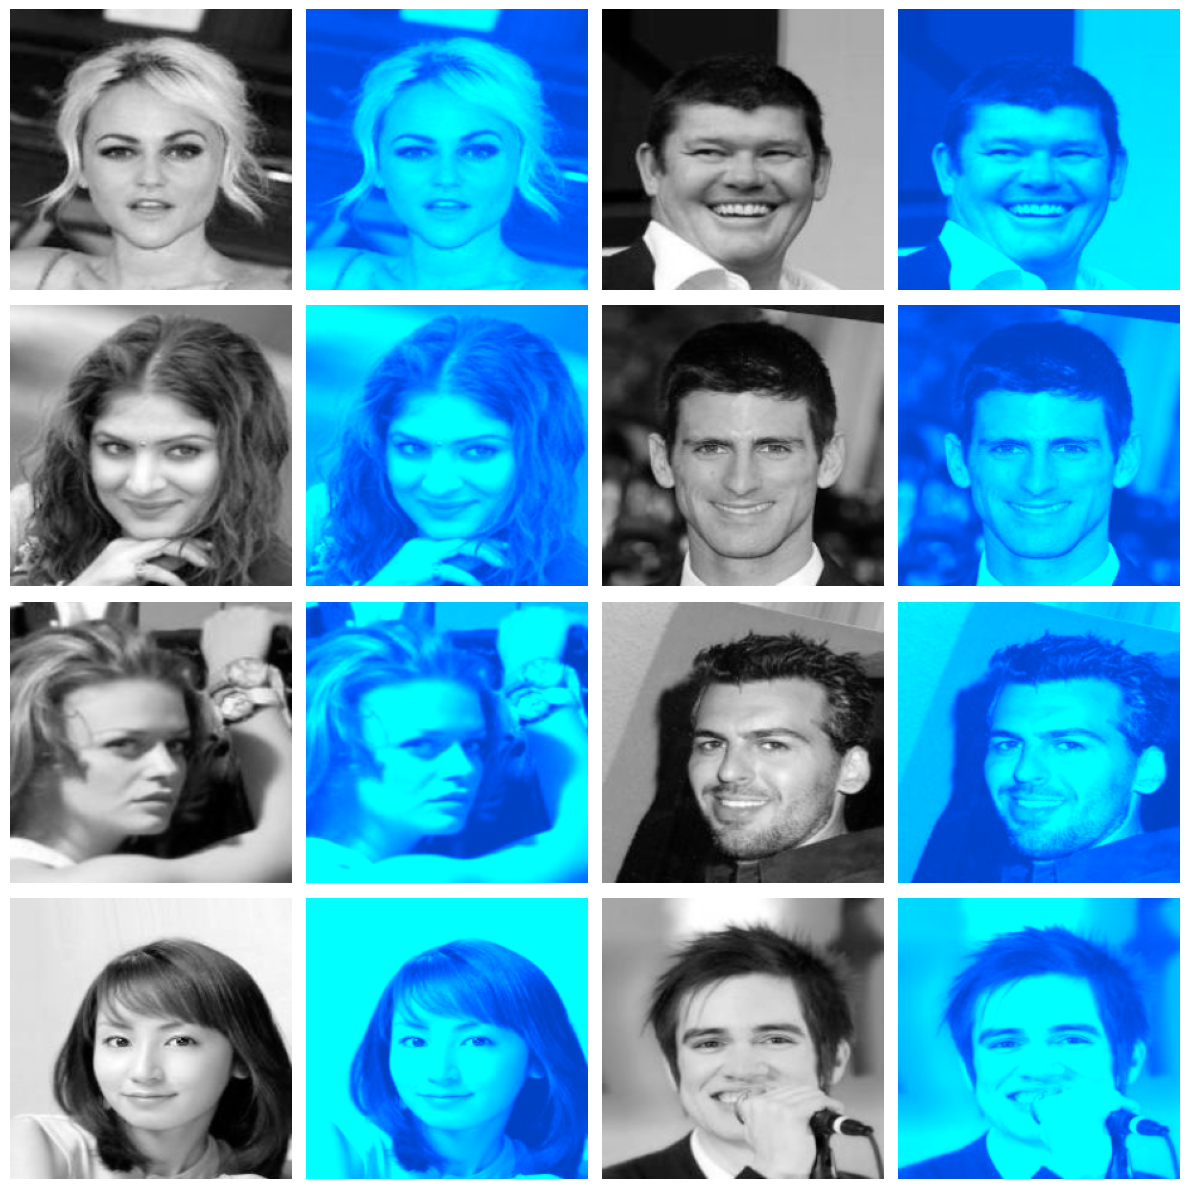

In [14]:
# # Cargar el dataset
# test_dataset = datasets.ImageFolder(root='path/to/your/test/dataset', transform=transform)
# test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Cargar el modelo entrenado
model = CAE()
checkpoint = torch.load('trained_models/CelebA_cae_1.0_0.001_full.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluación del modelo
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)
outputs = model(images)

# Visualización de resultados
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i in range(8):
    # Imagen en escala de grises
    gray_image = tensor_to_numpy(images[i]).squeeze()
    axs[i//2, (i % 2) * 2].imshow(gray_image, cmap='gray')
    axs[i//2, (i % 2) * 2].axis('off')

    # Imagen colorizada (predicción)
    ab_image = tensor_to_numpy(outputs[i])
    img_lab = np.zeros((224, 224, 3), dtype=np.float32)
    img_lab[:,:,0] = gray_image * 100  # L canal
    img_lab[:,:,1:] = (ab_image.transpose(1, 2, 0) - 0.5) * 255  # a y b canales
    img_rgb = lab2rgb(img_lab)
    axs[i//2, (i % 2) * 2 + 1].imshow(img_rgb)
    axs[i//2, (i % 2) * 2 + 1].axis('off')
plt.tight_layout()
plt.show()

In [15]:
def lab_to_rgb(L, ab):
    """
    Converts LAB images to RGB. The input L and ab should be tensors with the correct dimensions.
    """
    L = L.squeeze(0) * 100  # Escalar L de [0, 1] a [0, 100]
    ab = (ab * 255) - 128  # Escalar a y b de [0, 1] a [-128, 127]
    
    # Asegurarse de que las dimensiones sean consistentes para la concatenación
    Lab = torch.cat([L.unsqueeze(0), ab], dim=0).detach().cpu().numpy()  # Concatenar L y ab, y convertir a numpy
    img_rgb = lab2rgb(Lab.transpose(1, 2, 0))  # Transponer para tener la forma correcta
    return img_rgb

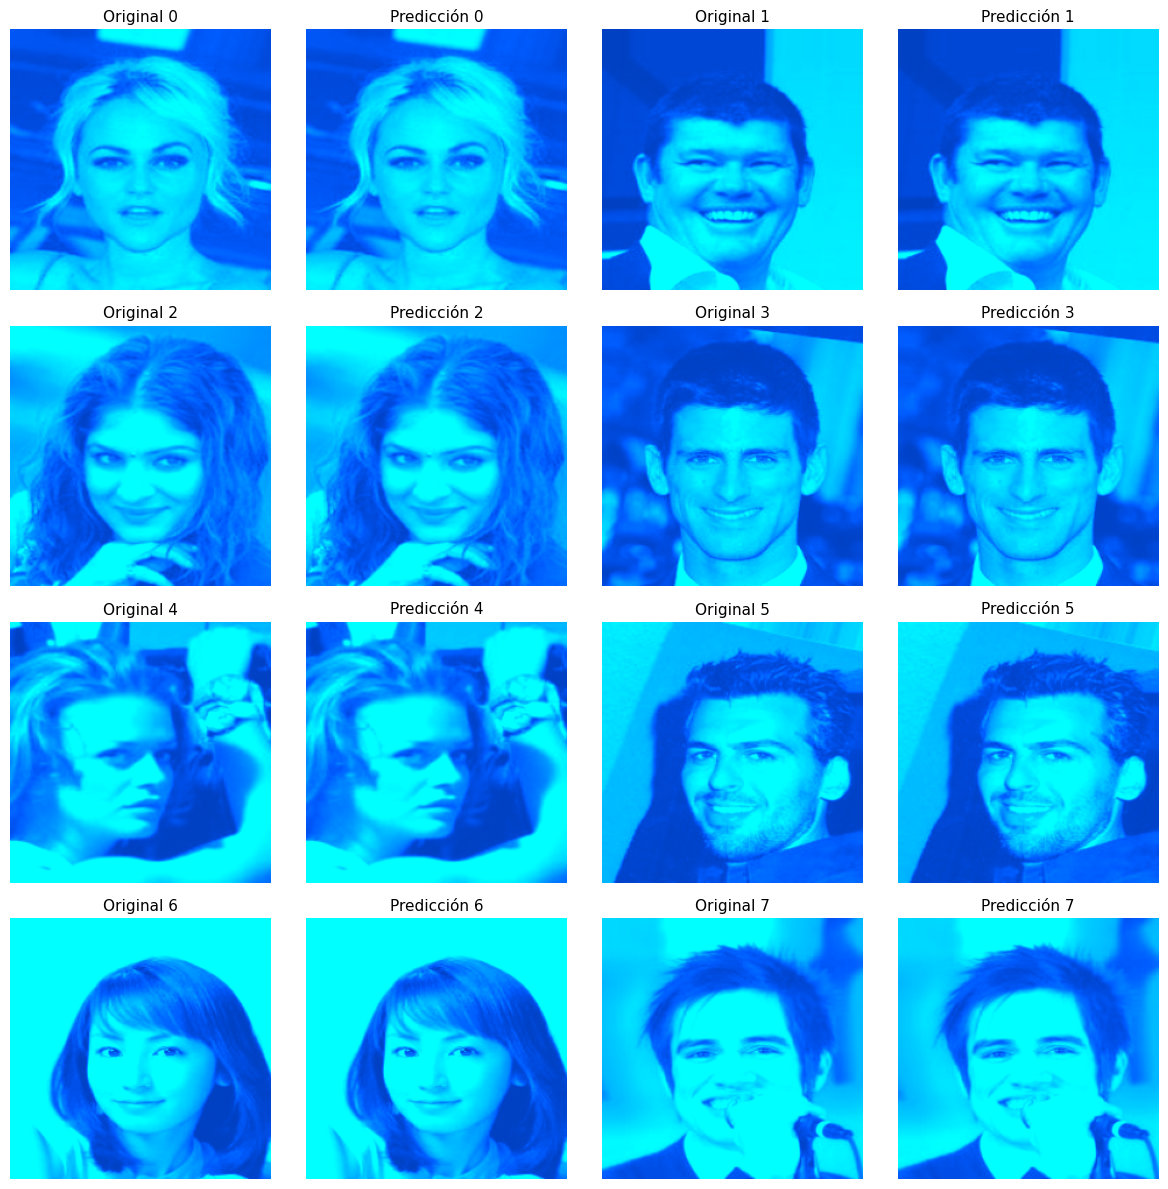

In [16]:
# Cargar el modelo entrenado
model = CAE()
checkpoint = torch.load('trained_models/CelebA_cae_1.0_0.001_full.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluación del modelo
dataiter = iter(test_loader)
l_images, ab_images = next(dataiter)
l_images, ab_images = l_images.to(device), ab_images.to(device)
output_ab = model(l_images)

# Convertir imágenes originales y predicciones a RGB
def lab_to_rgb_for_batch(L_batch, ab_batch):
    """
    Converts a batch of LAB images to RGB.
    """
    rgb_images = []
    for i in range(L_batch.size(0)):
        rgb_images.append(lab_to_rgb(L_batch[i], ab_batch[i]))
    return rgb_images

original_rgb = lab_to_rgb_for_batch(l_images, ab_images)
predicted_rgb = lab_to_rgb_for_batch(l_images, output_ab)

# Visualización de resultados
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

for i in range(8):
    # Imagen en color original
    axs[i//2, (i % 2) * 2].imshow(original_rgb[i])
    axs[i//2, (i % 2) * 2].axis('off')
    axs[i//2, (i % 2) * 2].set_title(f'Original {i}', fontsize=11)
    
    # Imagen colorizada (predicción)
    axs[i//2, (i % 2) * 2 + 1].imshow(predicted_rgb[i])
    axs[i//2, (i % 2) * 2 + 1].axis('off')
    axs[i//2, (i % 2) * 2 + 1].set_title(f'Predicción {i}', fontsize=11)

plt.tight_layout()
plt.show()

# Method 2

In [16]:
import os
from pathlib import Path

# Import glob to get the files directories recursively
import glob

# Import Garbage collector interface
import gc 

# Import OpenCV to transforme pictures
import cv2

# Import Time
import time

# import numpy for math calculations
import numpy as np

# Import pandas for data (csv) manipulation
import pandas as pd

# Import matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('fivethirtyeight') 
%matplotlib inline

import PIL
from PIL import Image
from skimage.color import rgb2lab, lab2rgb

import pytorch_lightning as pl

# Import pytorch to build Deel Learling Models 
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import models
from torch.nn import functional as F
import torch.utils.data
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

from torchsummary import summary

# Import tqdm to show a smart progress meter
from tqdm import tqdm

In [20]:
def lab_to_rgb(L, ab):
    L = L * 100  # Escalar L de [0, 1] a [0, 100]
    ab = (ab * 255) - 128  # Escalar a y b de [0, 1] a [-128, 127]
    Lab = torch.cat([L, ab], dim=0).detach().cpu().numpy()  # Concatenar L y ab, y convertir a numpy
    img_rgb = lab2rgb(Lab.transpose(1, 2, 0))  # Transponer para tener la forma correcta
    return img_rgb

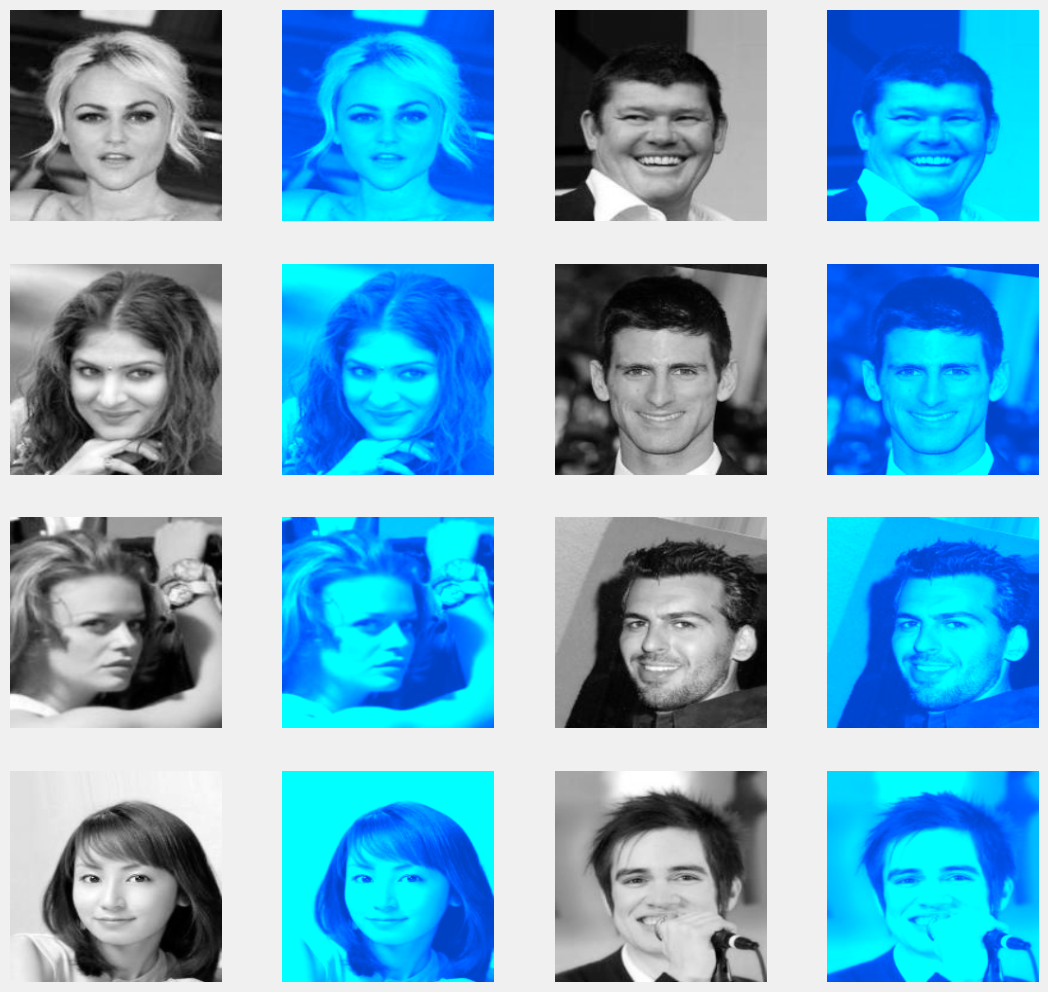

In [17]:
# imprimir las imagenes originales
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
for i in range(8):
    # Imagen en escala de grises
    gray_image = tensor_to_numpy(images[i]).squeeze()
    axs[i//2, (i % 2) * 2].imshow(gray_image, cmap='gray')
    axs[i//2, (i % 2) * 2].axis('off')

    # Imagen colorizada (predicción)
    ab_image = tensor_to_numpy(outputs[i])
    img_rgb = lab_to_rgb(images[i], outputs[i])
    axs[i//2, (i % 2) * 2 + 1].imshow(img_rgb)
    axs[i//2, (i % 2) * 2 + 1].axis('off')

In [23]:
def lab_to_rgb(L, ab):
    """
    Converts LAB images to RGB. The input L and ab should be tensors with the correct dimensions.
    """
    L = L.squeeze(0) * 100  # Escalar L de [0, 1] a [0, 100]
    ab = (ab * 255) - 128  # Escalar a y b de [0, 1] a [-128, 127]
    
    # Asegurarse de que las dimensiones sean consistentes para la concatenación
    Lab = torch.cat([L.unsqueeze(0), ab], dim=0).detach().cpu().numpy()  # Concatenar L y ab, y convertir a numpy
    img_rgb = lab2rgb(Lab.transpose(1, 2, 0))  # Transponer para tener la forma correcta
    return img_rgb


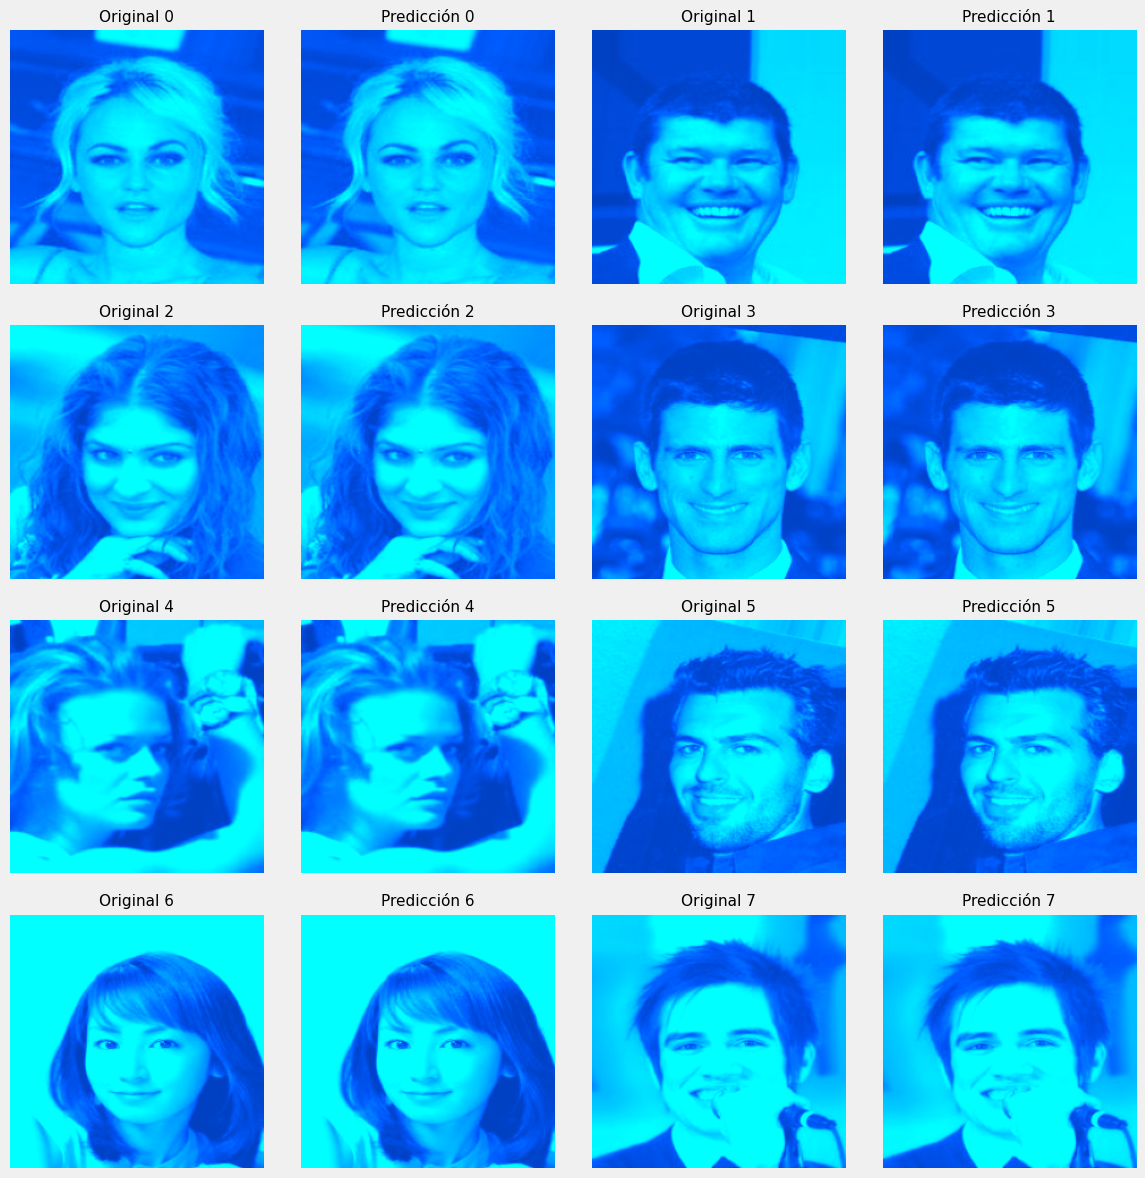

In [24]:
# Cargar el modelo entrenado
model = CAE()
checkpoint = torch.load('trained_models/CelebA_cae_1.0_0.001_full.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluación del modelo
dataiter = iter(test_loader)
l_images, ab_images = next(dataiter)
l_images, ab_images = l_images.to(device), ab_images.to(device)
output_ab = model(l_images)

# Convertir imágenes originales y predicciones a RGB
original_rgb = [lab_to_rgb(l_images[i], ab_images[i]) for i in range(l_images.size(0))]
predicted_rgb = [lab_to_rgb(l_images[i], output_ab[i]) for i in range(l_images.size(0))]

# Visualización de resultados
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

for i in range(8):
    # Imagen en color original
    axs[i//2, (i % 2) * 2].imshow(original_rgb[i])
    axs[i//2, (i % 2) * 2].axis('off')
    axs[i//2, (i % 2) * 2].set_title(f'Original {i}', fontsize=11)
    
    # Imagen colorizada (predicción)
    axs[i//2, (i % 2) * 2 + 1].imshow(predicted_rgb[i])
    axs[i//2, (i % 2) * 2 + 1].axis('off')
    axs[i//2, (i % 2) * 2 + 1].set_title(f'Predicción {i}', fontsize=11)

plt.tight_layout()
plt.show()

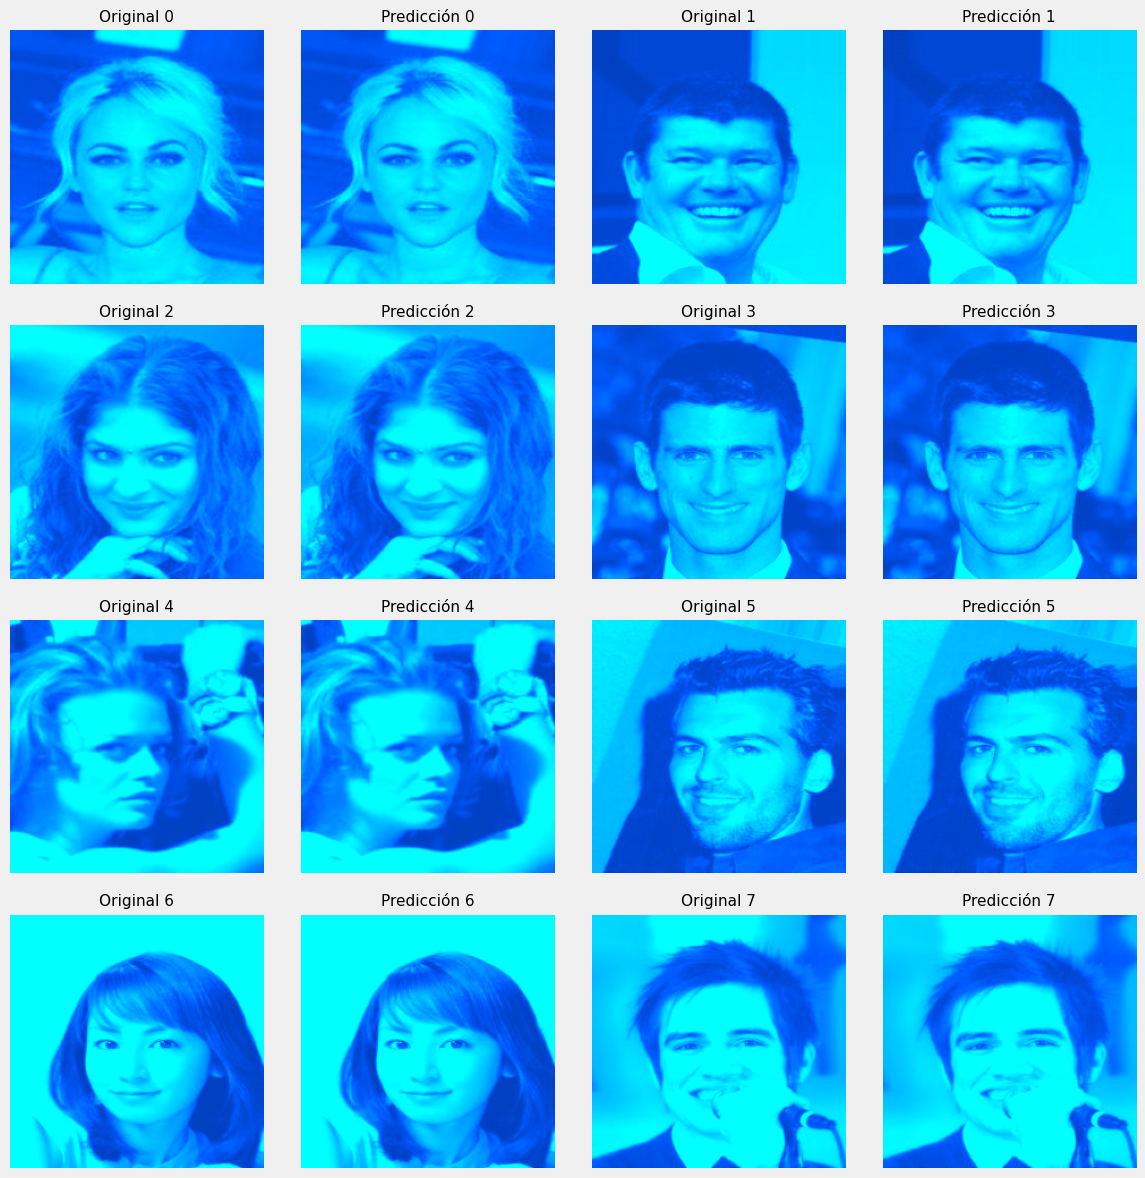

In [26]:
# Cargar el modelo entrenado
model = CAE()
checkpoint = torch.load('trained_models/CelebA_cae_1.0_0.001_9.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluación del modelo
dataiter = iter(test_loader)
l_images, ab_images = next(dataiter)
l_images, ab_images = l_images.to(device), ab_images.to(device)
output_ab = model(l_images)

# Convertir imágenes originales y predicciones a RGB
original_rgb = lab_to_rgb(l_images, ab_images)
predicted_rgb = lab_to_rgb(l_images, output_ab)

# Visualización de resultados
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

for i in range(8):
    # Imagen en color original
    axs[i//2, (i % 2) * 2].imshow(original_rgb[i])
    axs[i//2, (i % 2) * 2].axis('off')
    axs[i//2, (i % 2) * 2].set_title(f'Original {i}', fontsize=11)
    
    # Imagen colorizada (predicción)
    axs[i//2, (i % 2) * 2 + 1].imshow(predicted_rgb[i])
    axs[i//2, (i % 2) * 2 + 1].axis('off')
    axs[i//2, (i % 2) * 2 + 1].set_title(f'Predicción {i}', fontsize=11)

plt.tight_layout()
plt.show()